In [17]:
import os
import pandas as pd
import random
import seaborn as sns

In [2]:
directory = 'data/group3/config_1'
filename = random.choice(os.listdir(directory))
f = os.path.join(directory, filename)
data = pd.read_csv(f)
data.describe().T.sort_values(by='std', ascending=False)#iloc[:,1:].plot(kind='box')

,count,mean,std,min,25%,50%,75%,max
raw_acceleration_y,72.0,0.349306,3.577617,-6.390000,-1.545000,0.270000,1.86000,9.7500
raw_acceleration_x,72.0,-0.014583,2.715799,-8.820000,-1.422500,-0.105000,1.86750,6.8100
magnetic_field_y,72.0,15.624306,2.058312,11.870000,13.467500,16.435000,16.63750,19.5000
magnetic_field_x,72.0,-13.689722,1.616640,-17.060000,-15.180000,-13.500000,-12.68000,-10.3700
raw_acceleration_z,72.0,-10.064444,1.566218,-21.440000,-10.280000,-9.880000,-9.66250,-7.2400
magnetic_field_z,72.0,34.443889,1.420645,31.750000,33.370000,34.780000,35.37000,36.1800
rotation_speed_z,72.0,0.129722,0.728375,-1.510000,-0.215000,0.000000,0.56500,1.8200
t,72.0,49.872247,0.470933,49.073268,49.475153,49.871985,50.27388,50.6706
rotation_speed_x,72.0,0.033194,0.321194,-1.230000,-0.035000,0.000000,0.07000,1.2500
rotation_speed_y,72.0,-0.011806,0.282022,-0.910000,-0.040000,0.000000,0.02000,1.2700


* Données enregistrés sur un plan 2D donc seuleuement l'acceleration sur x et y ont une grande variance

In [3]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions

data['x'] = double_integrate(data,'raw_acceleration_x')
data['y'] = double_integrate(data,'raw_acceleration_y')
data = data.iloc[:,-2:]

In [4]:

# for timestep in range(len(data)):
#     print(data_scaled.iloc[[timestep],1:])

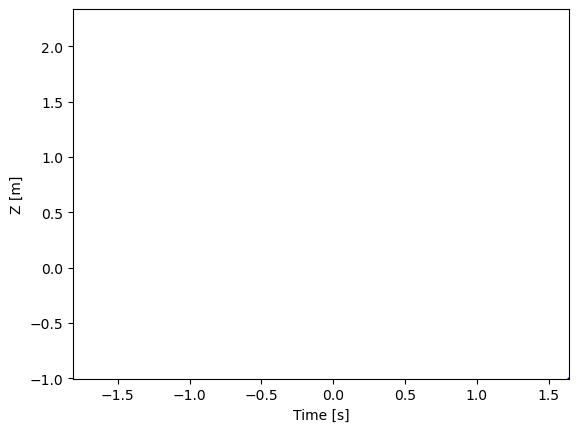

In [5]:
# %matplotlib widget

# prepare data
from sklearn.preprocessing import StandardScaler
# make figure
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import numpy as np

# prepare data
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
data_scaled=pd.DataFrame(sc.fit_transform(data), columns=data.columns)
data = data_scaled

# make figure
fig, ax = plt.subplots()
t = len(data)

scat = ax.scatter(data.x[0], data.y[0], c="b", s=5, label=f'v0 = m/s')
ax.set(xlim=[data.x.min(),data.x.max()],\
        ylim=[data.y.min(),data.y.max()],\
              xlabel='Time [s]', ylabel='Z [m]')

def update(frame):
    # for each frame, update the data stored on each artist.
    x = data.x[:frame]
    y = data.y[:frame]
    # update the scatter plot:
    data_slice = np.stack([x, y]).T
    scat.set_offsets(data_slice)
    return scat

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(data), interval=50)
plt.show()

# load data and train model

In [6]:
def linearize(u):
    """
    Fonction pour mettre en 1 seule lignes le tableau de statistiques pd.describe()
    """
    all=[]
    for line in range(len(u)):
        all.append(u.iloc[line])
    return pd.concat(all, axis=0).T

In [7]:
def load_data(directory='data/config1', drop_col='', drop_feat='', position=False, puissances=False, change_sign=False,n_segments=1):
    """
    Fonction pour charger les donnée:
    directory : str() chemin d'acces
    drop_col : list() nom des statistiques à ne pas utiliser (pd.describe())
    drop_feat : list() nom des features à ne pas utiliser
    position : bool() calcule la double integrale de l'acceleration
    puissances : bool() calcule la puisance cubique des rotations
    change_sign : bool() calcule le nombre de changement de signe de chaque variable
    n_segments : int() si >1 recalcule toutes les features pour n segments de l'acquisition

    return : pd.DataFrame()
    """
    all_data=[]
    for filename in sorted(os.listdir(directory)):
        # lecture fichier
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        # ajout des positions
        if position:
            data['pos_x'] = double_integrate(data,'raw_acceleration_x')
            data['pos_y'] = double_integrate(data,'raw_acceleration_y')
            data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        # ajout des puissances
        if puissances:
            data['rotation_cubic_x'] = data['rotation_speed_x']**3
            data['rotation_cubic_y'] = data['rotation_speed_y']**3
            data['rotation_cubic_z'] = data['rotation_speed_z']**3
        # feature selection / engineering 
        if drop_col:
            data.drop(columns=drop_col, inplace=True)
        u = data.describe().T
        if drop_feat:
            u.drop(columns=drop_feat, inplace=True)
        number = pd.DataFrame(linearize(u)).T
        # time segments
        if n_segments >1:
            n = len(data)//n_segments   # nbe de points par quartiers
            quartiles_ =[]
            for i in range(n_segments):
                quart_ = data[i*n:(i+1)*n]#.drop(columns='t')
                int_ = quart_.describe().T
                if drop_feat:
                    int_.drop(columns=drop_feat, inplace=True)
                number = pd.concat([number,pd.DataFrame(linearize(int_)).T],axis=1)
        # changement de signes
        if change_sign:
            for feature in data.columns[1:-1]:  # on ne prend pas le temps ni le label
                col_name = 'sign_change_' + feature
                data[col_name] = data[feature].apply(lambda x: 1 if x >= 0 else -1)
                number[col_name] = (data[col_name] * data[col_name].shift(-1) < 0).sum()
        # get correct label
        if directory == 'data/h_config1-lcb':
            number['label'] = filename[2]
        elif directory == 'data/v_config1-lcb':
            number['label'] = int(filename[10])
        elif directory == 'data/groupe1 - groupe2':
            number['groupe'] = filename[1]
            number['label'] = int(filename.split('_')[1])
        else :
            number['label'] = int(filename[0])
        # concatenate
        all_data.append(number)   
    return pd.concat(all_data)#, _.columns, u.columns

#### On entraine le randomforestclassifier sur toutes les données en 2D

In [12]:
to_test = load_data('data/group3/config_1', drop_col='t', drop_feat='count', position=True, puissances=False, change_sign=True,n_segments=3)
# to_test1 = load_data('data/h_config1-lcb', drop_col='t', drop_feat='count', position=True, puissances=False, change_sign=True,n_segments=3)
# to_test2 = load_data('data/v_config1-lcb', drop_col='t', drop_feat='count', position=True, puissances=False, change_sign=True,n_segments=3)
# to_test3 = pd.concat([to_test,to_test1,to_test2], axis=0)

In [14]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# prepare data
sc = StandardScaler()
X=sc.fit_transform(to_test3.drop("label", axis=1))
y=to_test3["label"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# define cross validation strategy
cv_search = KFold(n_splits=5, shuffle=True, random_state=42)
cv_test = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

In [36]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV

# Declare the hyperparameter grid
param_distributions = {
        'n_estimators': [50, 100, 200, 300, 500],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 8],
        "max_leaf_nodes": [10, 100, 1000, None],
        'max_features': ['auto', 'sqrt', 'log2'],
}


# Inner cross-validation for parameter search
model = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=2,max_features='sqrt'),
    param_distributions=param_distributions,
    n_iter=20,
    random_state=0,
    n_jobs=2,
    cv=cv_search,
    refit=True,
    return_train_score=True
)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

The mean score using nested cross-validation is: 0.939 ± 0.018


Text(0.5, 1.0, 'Train & Test score for the optimized model')

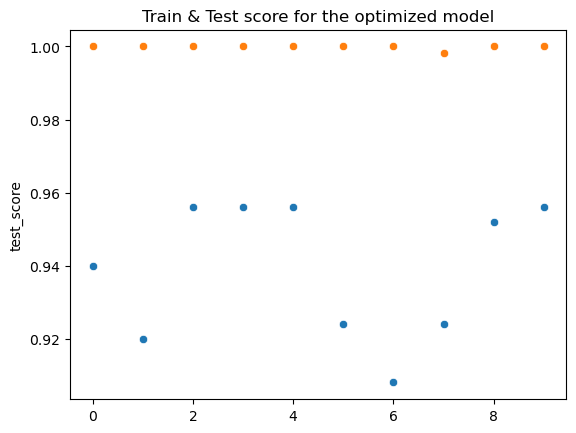

In [37]:

# Nested cross-validation
test_score = cross_validate(model, X, y, cv=cv_test, n_jobs=2, return_train_score=True, return_estimator=True)
print(
    "The mean score using nested cross-validation is: "
    f"{test_score['test_score'].mean():.3f} ± {test_score['test_score'].std():.3f}"
)

# plot train / test scores
sns.scatterplot(data=test_score,x=range(10),y='test_score')
sns.scatterplot(data=test_score,x=range(10),y='train_score')
plt.title('Train & Test score for the optimized model')

In [46]:
test_score['estimator'][9].best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 100,
 'max_features': 'auto',
 'max_depth': 40,
 'criterion': 'entropy'}

In [19]:
from sklearn.metrics import accuracy_score
# Get the best estimator from the outer loop
best_estimator_index = np.argmax(test_score['test_score'])
best_estimator = test_score['estimator'][best_estimator_index].best_estimator_
best_estimator.fit(X, y)
accuracy = accuracy_score(y, best_estimator.predict(X))
print("Accuracy on the entire dataset:", accuracy)

Accuracy on the entire dataset: 0.9975932611311673


In [ ]:
test_score = cross_validate(model, X_test, y_test, cv=10, n_jobs=2, return_train_score=True)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

In [ ]:
# # split the data
# X_train_outer, X_test, y_train_outer, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# # Perform nested cross-validation
# inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=2), param_distributions=param_distributions, cv=inner_cv)
# nested_score = cross_validate(grid_search, X_train_outer, y_train_outer, cv=outer_cv)
# print("Nested CV score: %.4f" % nested_score['test_score'].mean())

# # Fit the best model on the entire outer training set
# grid_search.fit(X_train_outer, y_train_outer)
# print("Test set score of best estimator: %.4f" % grid_search.score(X_test, y_test))
# print("Best Estimator:", grid_search.best_estimator_)

In [ ]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions


directory='data/group3/config_1'
drop_col='t'
drop_feat='count'
n_segments=3

all_data=[]
filename = random.choice(sorted(os.listdir(directory)))
# lecture fichier
f = os.path.join(directory, filename)
data__ = pd.read_csv(f)
print(f)

data/group3/config_1/6_8.csv


In [ ]:
# calcule les features à chaque pas de temps.
import time

def stepwise_predictions(data__):
    t=[]
    for i in range(len(data__)):
        data = data__.iloc[:i,:]   
        t0=time.time()
        # ajout des positions
        data['pos_x'] = double_integrate(data,'raw_acceleration_x')
        data['pos_y'] = double_integrate(data,'raw_acceleration_y')
        data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        # feature selection / engineering 
        data.drop(columns=drop_col, inplace=True)
        u = data.describe().T
        u.drop(columns=drop_feat, inplace=True)
        number = pd.DataFrame(linearize(u)).T
        # time segments
        n = len(data)//n_segments   # nbe de points par quartiers
        quartiles_ =[]
        for j in range(n_segments):
            quart_ = data[j*n:(j+1)*n]#.drop(columns='t')
            int_ = quart_.describe().T
            if drop_feat:
                int_.drop(columns=drop_feat, inplace=True)
            number = pd.concat([number,pd.DataFrame(linearize(int_)).T],axis=1)
        # changement de signes
        for feature in data.columns[1:-1]:  # on ne prend pas le temps ni le label
            col_name = 'sign_change_' + feature
            data[col_name] = data[feature].apply(lambda x: 1 if x >= 0 else -1)
            number[col_name] = (data[col_name] * data[col_name].shift(-1) < 0).sum()
        t.append(time.time()-t0)
        # get correct label
        number['label'] = filename[2]
        all_data.append(number)   
    return pd.concat(all_data), t

num,_ = stepwise_predictions(data__)
print(f"average feature caluation is {np.mean(_)}")

/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/2044368855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='t', inplace=True)
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/2044368855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='t', inplace=True)
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/2044368855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

average feature caluation is 0.03203240500556098


/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/1584473414.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = data[feature].apply(lambda x: 1 if x >= 0 else -1)
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/1584473414.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col_name] = data[feature].apply(lambda x: 1 if x >= 0 else -1)
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_3174/1584473414.py:30: SettingWithCopyWarning: 
A value is tr

In [ ]:
import numpy as np
preds = (model.best_estimator_.predict(sc.transform(num.drop(columns='label').fillna(0))) )

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# fonction qui 
def make_binary(arr):
    mask = np.zeros(10)
    mask[arr] = 1
    return mask

preds_bin = [make_binary(b) for b in preds]
target_bin = np.tile(make_binary(int(filename[0])),(len(preds),1))

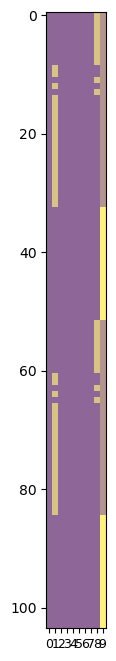

In [ ]:
fig, ax = plt.subplots(figsize=(1,8))
plt.imshow(preds_bin,alpha=0.5)
plt.imshow(target_bin,alpha=0.2)
ax.set_xticks(range(10))
ax.set_xticklabels(range(10),fontsize=9)
# ax.set_yticks(range(len(data__.t)))
# ax.set_yticklabels([round(a,3) for a in (data__.t-data__.t.min())])
plt.show()

IndexError: index 134 is out of bounds for axis 0 with size 52

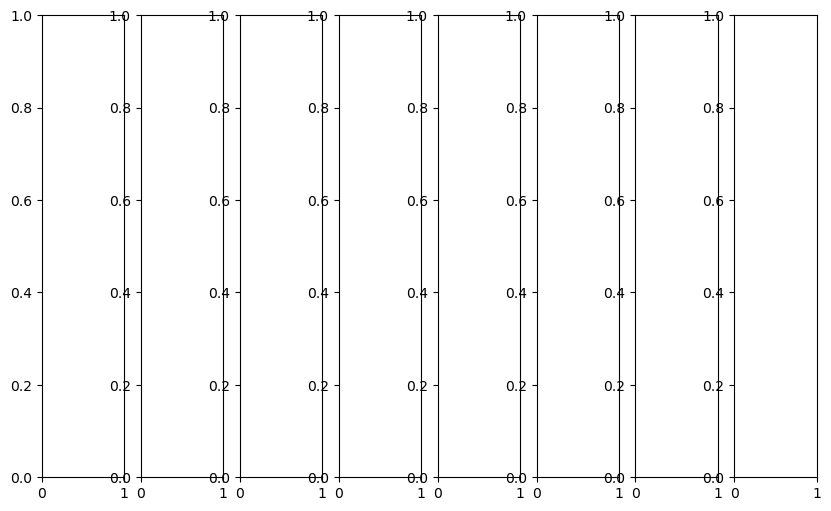

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 8, figsize=(10, 6))  
for i, n in enumerate(np.random.choice(len(y_test), 8, replace=False)):
    ax[i].imshow(preds[n],alpha=0.5)#,cmap='jet')
    ax[i].imshow(y_test[n],alpha=0.2)#, cmap='jet')
    #ax[i].imshow(Y_pred[n],alpha=0.5,cmap='jet')
    ax[i].axis('off') 
    ax[i].set_title(f"label={label_y_test[n]}\npredict={label_y_pred[n]}")
fig.suptitle("Images Visualization", fontsize=16)
fig.text(0.5, 0.01, 'timesteps', ha='center', fontsize=12)
plt.show()


In [ ]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)